In [1]:
import math
import matplotlib.pyplot as plt
import random

# LIF

In [2]:
# class LIF():
    
#     def __init__(self, I, neuron_type= "Inhibitory", t_total_ms = 100, dt_ms = 0.1, R = 10, tau = 8, threshold = -45,
#                  u_start = -80, u_rest = -79, u_reset = -65, u_spike = 5):
#         self.I = I
#         self.t_total_ms = t_total_ms
#         self.dt_ms = dt_ms
#         self.R = R
#         self.tau = tau
#         self.threshold = threshold
#         self.u_start = u_start
#         self.u_current = u_start
#         self.u_rest = u_rest
#         self.u_reset = u_reset
#         self.u_spike = u_spike
#         self.u_arr = []
#         self.fire_count = 0
#         self.neuron_type = neuron_type


#     def run(self):
#         t_current_ms = 0
#         while t_current_ms <= self.t_total_ms:
#             dudt = (-1 * (self.u_current - self.u_rest) + self.R * self.I(t_current_ms))/ self.tau
#             self.u_current += dudt * self.dt_ms
#             is_spike = False
#             if self.u_current >= self.threshold:
# #                 self.T = t_current_ms
#                 self.fire_count += 1
#                 self.u_arr.append(self.u_current + self.u_spike)
#                 is_spike = True
#                 self.u_current = self.u_reset
                
                
#             self.u_arr.append(self.u_current)
#             t_current_ms += self.dt_ms
#             yield {'u_current': self.u_current, 'is_spike': is_spike}
            
#     def u_plot(self):
#         t_arr =  range(len(self.u_arr))
#         plt.plot(list(map(lambda i: i * self.dt_ms, t_arr)), self.u_arr, c='g')
#         plt.suptitle("LIF", c= 'g', fontsize= 20)
#         plt.xlabel("Time (ms)")
#         plt.ylabel("Membrane Potential (mv)")
#         plt.show()
#         print("R: " + str(self.R) +
#         "    threshold: " + str(self.threshold) + 
#         "    u_rest: " + str(self.u_rest) + 
#         "    u_reset: " + str(self.u_reset) + 
#         "    u_spike: " + str(self.u_spike) + "\n"+
#         "u_start: " + str(self.u_start) +
#         "    tau: " + str(self.tau) + 
#         "    total time: " + str(self.t_total_ms) + 
#         "    dt: " + str(self.dt_ms))

#     def i_plot(self):
#         plt.plot(np.arange(0,100,0.1),list(map(I,np.arange(0,100,0.1))), c='r')
#         plt.suptitle("LIF", c= 'r', fontsize= 20)
#         plt.xlabel("Time (ms)")
#         plt.ylabel("Input Current (pA)")
#         plt.show()
#         print("R: " + str(self.R) +
#         "    threshold: " + str(self.threshold) + 
#         "    u_rest: " + str(self.u_rest) + 
#         "    u_reset: " + str(self.u_reset) + 
#         "    u_spike: " + str(self.u_spike) + "\n"+
#         "u_start: " + str(self.u_start) +
#         "    tau: " + str(self.tau) + 
#         "    total time: " + str(self.t_total_ms) + 
#         "    dt: " + str(self.dt_ms))
        
#     def f_plot(self):
#         freq_arr = []
#         for i in list(np.arange(1,8,0.5)):
#             I = lambda x: i
#             lif = LIF(I=I)
#             lif.run()
#             freq_arr.append(lif.fire_count/lif.t_total_ms)
#         plt.plot(range(len(freq_arr)), freq_arr, 'y')
#         plt.show()

class LIF():


    def __init__(self, I, total_time_ms=100, dt_ms=0.1, neuron_type='Excitatory',
    threshold=-45, u_rest=-70, start_u=-80, u_reset=-65, u_spike=5, R=10, tau=8, 
    is_exponential=False, delta_T=1, theta_r_h=-55,
    is_adaptive=False, a=0.01, b=0.5, tau_w=1):
        self.I = I
        self.total_time_ms = total_time_ms
        self.dt_ms = dt_ms
        self.neuron_type = neuron_type
        self.u_arr = []
        self.w_t = []
        self.fire_count = 0
        self.u_current = start_u
        self.start_u = start_u
        self.threshold = threshold
        self.u_rest = u_rest
        self.u_reset = u_reset
        self.u_spike = u_spike
        self.R = R
        self.tau = tau
        self.is_exponential = is_exponential
        self.delta_T = delta_T
        self.theta_r_h = theta_r_h
        self.is_adaptive = is_adaptive
        self.a = a
        self.b = b
        self.tau_w = tau_w
        self.w = 0

    def run(self):
        current_time = 0
        while current_time <= self.total_time_ms:
            exponential_value = 0
            adaptation_value = 0
            delta_u = self.u_current - self.u_rest

            if self.is_adaptive:
                dw = (self.a * delta_u - self.w) / self.tau_w 
                dw += self.b * self.fire_count
                self.w += dw * self.dt_ms
                adaptation_value = self.R * self.w


            if self.is_exponential:
                exponential_value = self.delta_T * math.exp((self.u - self.theta_r_h)/self.delta_T)

            du = -1 * delta_u + exponential_value - adaptation_value + self.R * self.I(current_time)
            du /= self.tau
            
            self.u_current += du * self.dt_ms
            is_spike = False
            if self.u_current >= self.threshold:
                self.u_arr.append(self.u_current + self.u_spike)
                self.fire_count += 1
                self.u_current = self.u_reset
                is_spike = True

            self.w_t.append(self.w)
            self.u_arr.append(self.u_current)

            current_time += self.dt_ms

            yield {'u_current': self.u_current, 'is_spike': is_spike}


    def u_plot(self):
        plt.plot(list(map(lambda i: i * self.dt_ms, range(len(self.u_arr)))), self.u_arr)
        plt.show()


    def w_t_plot(self):
        if self.is_adaptive == True:
          plt.plot(list(map(lambda i: i * self.dt_ms, range(len(self.w_t)))), self.w_t)
          plt.show()
        else:
          print("This model isn't adaptive")



# NeuronsGroup

In [3]:
class NeuronsGroup:

  def __init__(self, neurons, connections, exc_w=10, inh_w=-10, exc_d=1, inh_d=1, total_time=1000):
    self.neurons = neurons
    self.action = []
    for i in neurons:
      self.action.append(i.run()) 

    self.connections = connections
    self.exc_w = exc_w
    self.inh_w = inh_w
    self.exc_d = exc_d
    self.inh_d =  inh_d
    self.total_time = total_time
    self.spikes = []
    self.t_exc_spikes = []
    self.exc_spikes = []
    self.t_inh_spikes = []
    self.inh_spikes = []
    self.s_effect = []

  def run(self):
    
    #create array of zeros for each neurons spikes effect
    self.s_effect = [[0] * len(self.neurons) for p in range(self.total_time)] 
    
    #iterate through total time
    for time in range(self.total_time):  
      #iterate through all neurons actions
      for i in range(len(self.action)):
        a_info = next(self.action[i])
        if a_info['is_spike']:
    
          #iterate through connected neurons 
          for j in self.connections[i]:
            
            #Inhibitory spike
            if self.neurons[i].neuron_type == 'Inhibitory':
              if self.total_time > time + self.exc_d:
                self.s_effect[time + self.inh_d][j] += self.inh_w
              self.inh_spikes.append(i + 1)
              self.t_inh_spikes.append(time)
            
            #Excitatory spike
            if self.neurons[i].neuron_type == 'Excitatory':
              if self.total_time > time + self.inh_d:
                self.s_effect[time + self.exc_d][j] += self.exc_w
              self.exc_spikes.append(i + 1)
              self.t_exc_spikes.append(time)
              
      #add the effect of each neuron to the neurons potential
      for i in range(len(self.neurons)):
        self.neurons[i].u_current += self.s_effect[time][i]
      
  def raster_plot(self):
    plt.scatter(self.t_inh_spikes, self.inh_spikes, color='blue', label = 'Inhibitory')
    plt.scatter(self.t_exc_spikes, self.exc_spikes, color='green', label = 'Excitatory')
    plt.legend(loc="lower right")

  def u_plot(self, n_neurons=3):
    if n_neurons < len(self.neurons):
      for i in range(n_neurons):
        arr = list(map(lambda p: self.neurons[i].dt_ms * p, range(len(self.neurons[i].u_arr))))
        plt.plot(arr, self.neurons[i].u_arr, label = "neuron " + str(i+1))
        plt.legend(loc="lower right")
    else:
      for i in range(len(self.neurons)):
        arr = list(map(lambda p: self.neurons[i].dt_ms * p, range(len(self.neurons[i].u_arr))))
        plt.plot(arr, self.neurons[i].u_arr , label = "neuron " + str(i+1))
        plt.legend(loc="lower right")
    
  
# class NeuronsGroup:

#   def __init__(self, neurons, connections, excw=10, inhw=-10, exc_delay=1, inh_delay=1, iteration_count=1000):
#     self.neurons = neurons
#     self.neroun_action = []
#     for i in neurons:
#       self.neroun_action.append(i.run())

#     self.connections = connections
#     self.excw = excw
#     self.inhw = inhw
#     self.iteration_count = iteration_count
#     self.spikes = []
#     self.exc_spikes_time = []
#     self.exc_spikes = []
#     self.inh_spikes_time = []
#     self.inh_spikes = []
#     self.exc_delay = exc_delay
#     self.inh_delay = inh_delay
#     self.spikes_effect = []

#   def run(self):
#     self.spikes_effect = [[0] * len(self.neurons) for _ in range(self.iteration_count)]
#     for t in range(self.iteration_count):
#       flag = False
      
#       for i in range(len(self.neroun_action)):

#         action_info = next(self.neroun_action[i])
#         if action_info['is_spike']:
          
#           for j in self.connections[i]:
#             if self.neurons[i].neuron_type == 'Excitatory':
#               self.exc_spikes.append(i + 1)
#               self.exc_spikes_time.append(t)
#               if t+self.exc_delay < self.iteration_count:
#                 self.spikes_effect[t + self.exc_delay][j] += self.excw

#             if self.neurons[i].neuron_type == 'Inhibitory':
#               self.inh_spikes.append(i + 1)
#               self.inh_spikes_time.append(t)
#               if t+self.inh_delay < self.iteration_count:
#                 self.spikes_effect[t+self.inh_delay][j] += self.inhw
#       for i in range(len(self.neurons)):
#         self.neurons[i].u_current += self.spikes_effect[t][i]
      

#   def u_plot(self, neurons_count=5):
#     legend = []
#     for i in range(min(neurons_count, len(self.neurons))):
#       plt.plot(list(map(lambda j: j * self.neurons[i].dt_ms, range(len(self.neurons[i].u_arr)))), self.neurons[i].u_arr)
#       legend.append('neuron ' + str(i+1))
#     plt.legend(legend)

#   def raster_plot(self):
#     plt.scatter(self.exc_spikes_time, self.exc_spikes, color='blue', s=10)
#     plt.scatter(self.inh_spikes_time, self.inh_spikes, color='red', s=10)
#     plt.legend(['Excitatory', 'Inhibitory'])  

# class NeuronsGroup:

#   def __init__(self, neurons, connections, excw=10, inhw=-10, exc_delay=1, inh_delay=1, iteration_count=1000):
#     self.neurons = neurons
#     self.neroun_action = []
#     for i in neurons:
#       self.neroun_action.append(i.start())

#     self.connections = connections
#     self.excw = excw
#     self.inhw = inhw
#     self.iteration_count = iteration_count
#     self.spikes = []
#     self.exc_spikes_time = []
#     self.exc_spikes = []
#     self.inh_spikes_time = []
#     self.inh_spikes = []
#     self.exc_delay = exc_delay
#     self.inh_delay = inh_delay
#     self.spikes_effect = []

#   def start(self):
#     self.spikes_effect = [[0] * len(self.neurons) for _ in range(self.iteration_count)]
#     for t in range(self.iteration_count):
#       flag = False
      
#       for i in range(len(self.neroun_action)):

#         action_info = next(self.neroun_action[i])
#         if action_info['is_spike']:
          
#           for j in self.connections[i]:
#             if self.neurons[i].neuron_type == 'Excitatory':
#               self.exc_spikes.append(i + 1)
#               self.exc_spikes_time.append(t)
#               if t+self.exc_delay < self.iteration_count:
#                 self.spikes_effect[t + self.exc_delay][j] += self.excw

#             if self.neurons[i].neuron_type == 'Inhibitory':
#               self.inh_spikes.append(i + 1)
#               self.inh_spikes_time.append(t)
#               if t+self.inh_delay < self.iteration_count:
#                 self.spikes_effect[t+self.inh_delay][j] += self.inhw
#       for i in range(len(self.neurons)):
#         self.neurons[i].u += self.spikes_effect[t][i]
      

#   def neurons_u_plot(self, neurons_count=5):
#     legend = []
#     for i in range(min(neurons_count, len(self.neurons))):
#       plt.plot(list(map(lambda j: j * self.neurons[i].delta_t_ms, range(len(self.neurons[i].u_t)))), self.neurons[i].u_t)
#       legend.append('neuron ' + str(i+1))
#     plt.legend(legend)

#   def raster_plot(self):
#     plt.scatter(self.exc_spikes_time, self.exc_spikes, color='blue', s=10)
#     plt.scatter(self.inh_spikes_time, self.inh_spikes, color='red', s=10)
#     plt.legend(['Excitatory', 'Inhibitory'])
  

### Two Neurons 

In [4]:
I1 = lambda x: 5 
I2 = lambda x: math.sin(x/10)+3

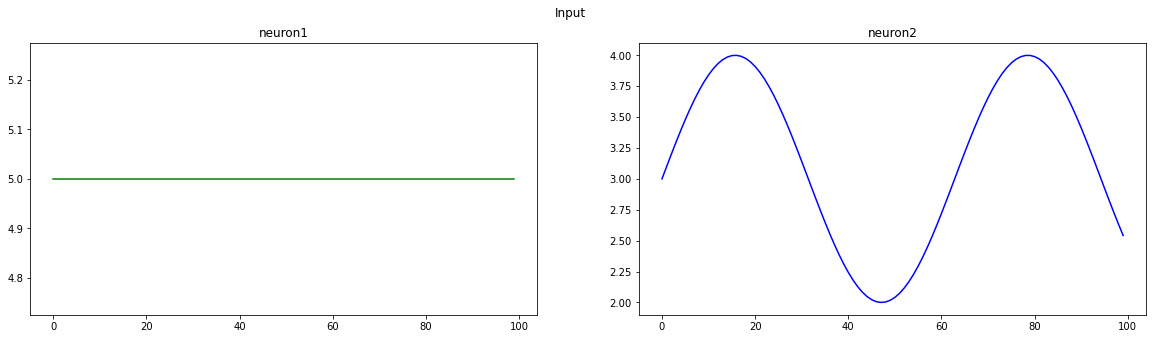

In [5]:
plot, (plt1, plt2) = plt.subplots(1, 2)
plt1.plot(range(100), list(map(I1, range(100))), 'g')
plt1.set_title('neuron1')
plt2.plot(range(100), list(map(I2, range(100))), 'b')
plt2.set_title('neuron2')
plot.suptitle('Input')
plot.set_size_inches(20, 5)



#### Inhibitory - Inhibitory

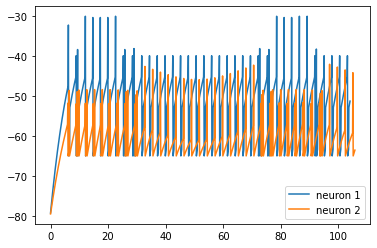

In [6]:
neuron1 = LIF(I=I1)
neuron2 = LIF(I=I2, threshold = -57)

neurons = [neuron1, neuron2]
connections = [[1], [0]]
group = NeuronsGroup(neurons, connections)
group.run()
group.u_plot()

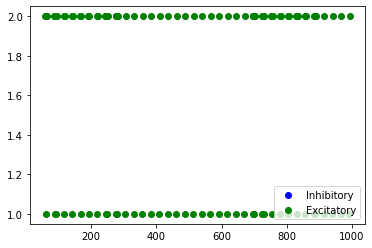

In [7]:
group.raster_plot()

#### Inhibitory - Excitatory

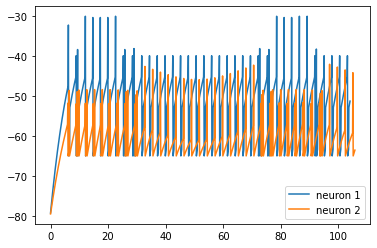

In [8]:
neuron1 = LIF(I=I1)
neuron2 = LIF(I=I2, neuron_type='Excitatory', threshold = -57)

neurons = [neuron1, neuron2]
connections = [[1], [0]]
group = NeuronsGroup(neurons, connections)
group.run()
group.u_plot()

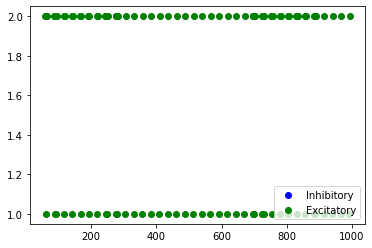

In [9]:
group.raster_plot()

#### Excitatory - Excitatory

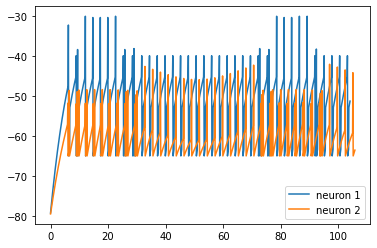

In [10]:
neuron1 = LIF(I=I1, neuron_type='Excitatory')
neuron2 = LIF(I=I2, neuron_type='Excitatory', threshold = -57)

neurons = [neuron1, neuron2]
connections = [[1], [0]]
group = NeuronsGroup(neurons, connections)
group.run()
group.u_plot()

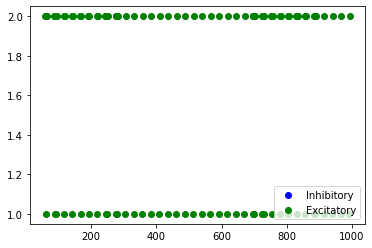

In [11]:
group.raster_plot()

### Multiple Neurons 

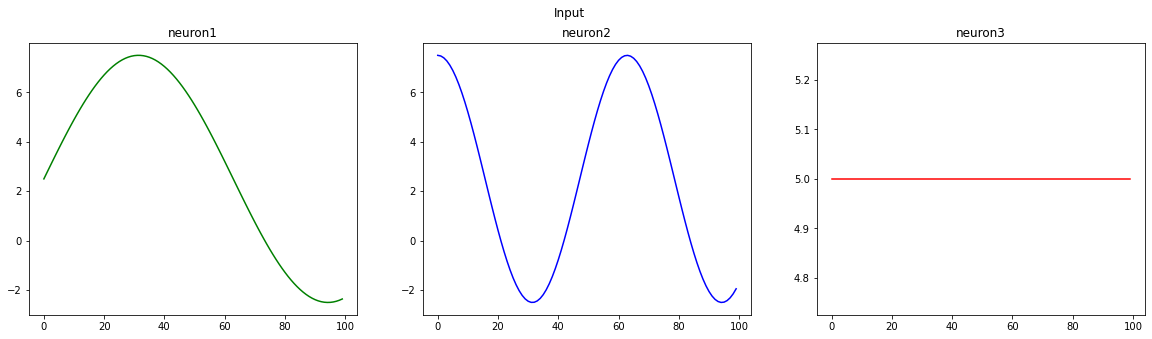

In [12]:
I1 = lambda x: (math.sin(x/20) + 0.5) * 5
I2 = lambda x: (math.cos(x/10) + 0.5) * 5
I3 = lambda x: 5

plot, (plt1, plt2, plt3) = plt.subplots(1, 3)
plt1.plot(range(100), list(map(I1, range(100))), 'g')
plt1.set_title('neuron1')
plt2.plot(range(100), list(map(I2, range(100))), 'b')
plt2.set_title('neuron2')
plt3.plot(range(100), list(map(I3, range(100))), 'r')
plt3.set_title('neuron3')
plot.suptitle('Input')
plot.set_size_inches(20, 5)



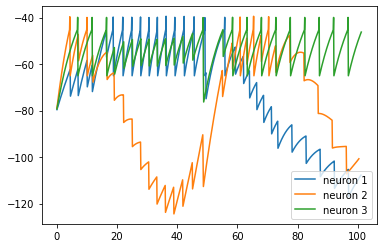

In [13]:
neuron1 = LIF(I=I1)
neuron2 = LIF(I=I2)
neuron3 = LIF(I=I3, neuron_type='Excitatory')

neurons = [neuron1, neuron2, neuron3]
connections = [[1,2], [0], [0,1]]
group = NeuronsGroup(neurons, connections, inh_d=6, exc_w=-12)
group.run()
group.u_plot()

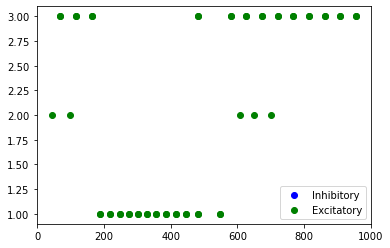

In [14]:
group.raster_plot()

# Neurons Group

In [59]:
# def create_group(exc_count, inh_count, I):
#   neurons_count = exc_count + inh_count
#   neurons = []
#   connections = []

#   for i in range(exc_count):
#     neuron = LIF(I[i], neuron_type='Excitatory')
#     neurons.append(neuron)
#     connections.append(range(neurons_count))
#   for i in range(inh_count):
#     neuron = LIF(I[i], neuron_type='Inhibitory')
#     neurons.append(neuron)
#     connections.append(range(neurons_count))
  
#   neurons_group = NeuronsGroup(neurons, connections)
#   return neurons_group
   


def create_neuron_group(exc_count, inh_count, exc_chance, inh_chance, I):
      
  neurons_count = inh_count + exc_count
  neurons = []
  total_connections = []
  
  inh_connections = int(neurons_count * inh_chance)
  exc_connections = int(neurons_count * exc_chance)
    
  for i in range(inh_count):
    neuron = LIF(I[i], neuron_type = 'Inhibitory')
    neurons.append(neuron)
    random_inh_connections = random.sample(range(neurons_count), inh_connections)
    total_connections.append(random_inh_connections)
    
  for i in range(exc_count):
    neuron = LIF(I[i], neuron_type = 'Excitatory')
    neurons.append(neuron)
    random_exc_connections = random.sample(range(neurons_count), exc_connections)
    total_connections.append(random_exc_connections)

    
  neurons_group = NeuronsGroup(neurons, total_connections)
  return neurons_group
   



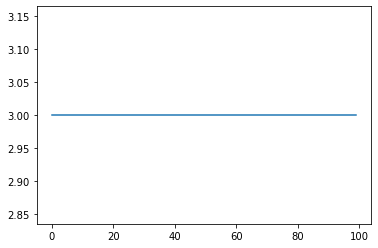

In [126]:
plt.plot(range(100), list(map(lambda x: 3, range(100))))


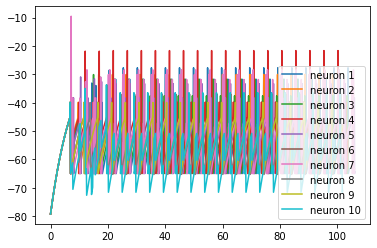

In [135]:
I_arr = []
for i in range(10):
  I = lambda x: 5
  I_arr.append(I)

group = create_neuron_group(8, 2, 0.2, 0.1, I_arr)

group.run()
group.u_plot(10)

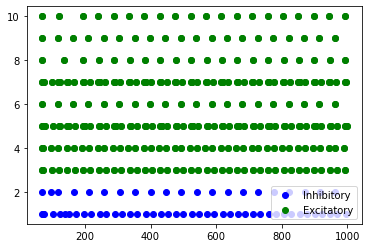

In [136]:
group.raster_plot()

### All neurons connected

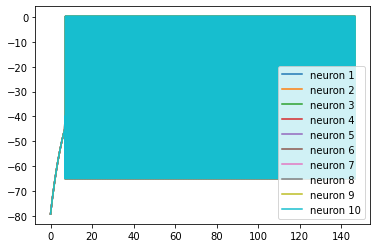

In [140]:
I_arr = []
for i in range(10):
  I = lambda x: 5
  I_arr.append(I)
    
group = create_neuron_group(8, 2, 1, 1, I_arr)

group.run()
group.u_plot(10)

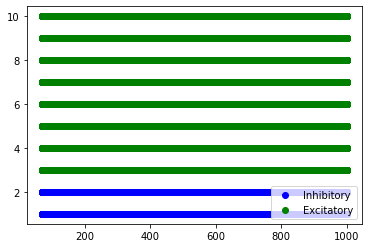

In [141]:
group.raster_plot()